In [1]:
!pip -q install spotipy
!pip -q install -U librosa

In [2]:
import matplotlib.pyplot as plt
import pandas as pd 
import spotipy 
import librosa
import librosa.display
import numpy as np
import matplotlib as mpl
import urllib.request
import seaborn as sns
import tqdm
import scipy
import joblib
from pathlib import Path
from IPython.display import Audio, Markdown, Image
from spotipy.oauth2 import SpotifyClientCredentials 


# Números y Datos
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.interpolate import interp1d

# Análisis de sonido
import librosa
import librosa.display
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials 

from scipy.signal import savgol_filter

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

#sns.set_context('poster')
sns.set_style('darkgrid')

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [3]:
df_af = pd.read_pickle('audio_features.pickle')
df_tracks = pd.read_pickle('tracks.pickle')
df_af = df_af.drop('duration_ms',1)
#df_aa = pd.read_pickle('audio_analysis.pickle').set_index('id')

In [4]:
#dff = df_tracks.sample(1000)
df_m = df_tracks.merge(df_af, on='id', how='left')
df_m = df_m.drop(['type_x','type_y','uri_x','uri_y',
                  'track_href','analysis_url','href','preview_url',
                 'external_ids'], 1)
df_m.head(3).T

id                                            4d3XHYFFuYYzxWr2cJ6yQl  \
album              {'album_type': 'ALBUM', 'artists': [{'external...   
artists                                               Tommy Flanagan   
available_markets  [AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...   
disc_number                                                        1   
duration_ms                                                   349600   
explicit                                                       False   
external_urls      {'spotify': 'https://open.spotify.com/track/4d...   
is_local                                                       False   
name                                             Angel Eyes - Studio   
popularity                                                        49   
track_number                                                       3   
genre                                                           jazz   
danceability                                                   0.487   
energy                                                         0.145   
key                                                                5   
loudness                                                      -18.67   
mode                                                               1   
speechiness                                                   0.0522   
acousticness                                                   0.876   
instrumentalness                                               0.822   
liveness                                                       0.149   
valence                                                        0.142   
tempo                                                        110.134   
time_signature                                                     4   

id                                            3X3p3u03P8eFL8WTH0oaaU  \
album              {'album_type': 'ALBUM', 'artists': [{'external...   
artists                                                   Art Farmer   
available_markets  [AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...   
disc_number                                                        1   
duration_ms                                                   344066   
explicit                                                       False   
external_urls      {'spotify': 'https://open.spotify.com/track/3X...   
is_local                                                       False   
name                                       Fair Weather - Remastered   
popularity                                                        47   
track_number                                                       2   
genre                                                           jazz   
danceability                                                   0.615   
energy                                                         0.204   
key                                                                7   
loudness                                                     -16.075   
mode                                                               1   
speechiness                                                   0.0439   
acousticness                                                   0.872   
instrumentalness                                               0.382   
liveness                                                       0.071   
valence                                                        0.496   
tempo                                                          96.47   
time_signature                                                     4   

id                                            4KlXeaheot0OI9PoOWspvZ  
album              {'album_type': 'ALBUM', 'artists': [{'external...  
artists                                Christian Scott aTunde Adjuah  
available_markets                                           [CA, US]  
disc_number                                                        1  
duration_ms                                

In [5]:
df_m[df_m.isnull().any(axis=1)].head()

Empty DataFrame
Columns: [album, artists, available_markets, disc_number, duration_ms, explicit, external_urls, is_local, name, popularity, track_number, genre, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, time_signature]
Index: []

[0 rows x 24 columns]

In [6]:
df_m.select_dtypes([np.number])

disc_number  duration_ms  popularity  track_number  \
id                                                                           
4d3XHYFFuYYzxWr2cJ6yQl            1       349600          49             3   
3X3p3u03P8eFL8WTH0oaaU            1       344066          47             2   
4KlXeaheot0OI9PoOWspvZ            1       348746          13             5   
3j76McoUI18gDoqxYE14Bu            1       275935          25             8   
4zxd4tiXPlWMqoJltbVTbE            2       284560          56             3   
...                             ...          ...         ...           ...   
5vSsQH8wH68PDKJbNfxzpc            1       479817          17             1   
7xYKAlU77jAAnAixQ5IgSn            1       569133           0            14   
4hXEgyy5nNgdiBvJcJ9o8u            1       200563           0             2   
4HpSbJgNpoOphIeCK3z9sk            1       187240           0             1   
30KzbX1viF0aTL1NS5coDY            1       309346           0             3   

                        danceability  energy  key  loudness  mode  \
id                                                                  
4d3XHYFFuYYzxWr2cJ6yQl         0.487   0.145    5   -18.670     1   
3X3p3u03P8eFL8WTH0oaaU         0.615   0.204    7   -16.075     1   
4KlXeaheot0OI9PoOWspvZ         0.792   0.301    9    -9.925     0   
3j76McoUI18gDoqxYE14Bu         0.670   0.532    2   -16.138     1   
4zxd4tiXPlWMqoJltbVTbE         0.485   0.144   10   -12.824     1   
...                              ...     ...  ...       ...   ...   
5vSsQH8wH68PDKJbNfxzpc         0.454   0.991    2    -6.228     0   
7xYKAlU77jAAnAixQ5IgSn         0.572   0.802    5   -12.491     0   
4hXEgyy5nNgdiBvJcJ9o8u         0.673   0.795    9    -8.033     1   
4HpSbJgNpoOphIeCK3z9sk         0.569   0.728    1    -6.648     1   
30KzbX1viF0aTL1NS5coDY         0.616   0.894    5    -7.845     0   

                        speechiness  acousticness  instrumentalness  liveness  \
id                                                                              
4d3XHYFFuYYzxWr2cJ6yQl       0.0522      0.876000          0.822000    0.1490   
3X3p3u03P8eFL8WTH0oaaU       0.0439      0.872000          0.382000    0.0710   
4KlXeaheot0OI9PoOWspvZ       0.0409      0.546000          0.821000    0.0770   
3j76McoUI18gDoqxYE14Bu       0.0313      0.708000          0.657000    0.6570   
4zxd4tiXPlWMqoJltbVTbE       0.0362      0.912000          0.000114    0.0965   
...                             ...           ...               ...       ...   
5vSsQH8wH68PDKJbNfxzpc       0.0454      0.000017          0.915000    0.1700   
7xYKAlU77jAAnAixQ5IgSn       0.0310      0.000499          0.831000    0.5470   
4hXEgyy5nNgdiBvJcJ9o8u       0.0433      0.008060          0.848000    0.5630   
4HpSbJgNpoOphIeCK3z9sk       0.0353      0.083600          0.003180    0.4220   
30KzbX1viF0aTL1NS5coDY       0.0285      0.014600          0.130000    0.1070   

                        valence    tempo  time_signature  
id                                                        
4d3XHYFFuYYzxWr2cJ6yQl    0.142  110.134               4  
3X3p3u03P8eFL8WTH0oaaU    0.496   96.470               4  
4KlXeaheot0OI9PoOWspvZ    0.424   89.878               4  
3j76McoUI18gDoqxYE14Bu    0.334  116.479               4  
4zxd4tiXPlWMqoJltbVTbE    0.246   86.143               4  
...                         ...      ...             ...  
5vSsQH8wH68PDKJbNfxzpc    0.226  140.016               4  
7xYKAlU77jAAnAixQ5IgSn    0.111  135.921               4  
4hXEgyy5nNgdiBvJcJ9o8u    0.478  131.006               4  
4HpSbJgNpoOphIeCK3z9sk    0.493  126.994               4  
30KzbX1viF0aTL1NS5coDY    0.526  130.337               4  

[4092 rows x 16 columns]

Rangos normalizados por cuantiles

In [7]:
quantil=50 # decil
df_num = df_m.copy()
df_num = df_num.drop(['explicit','album','artists','available_markets','disc_number','external_urls','is_local','time_signature'],1)
for k in df_num.select_dtypes([np.number]).columns:
    df_num[k] = np.ceil(df_num[k].rank().mul(quantil/len(df_num))).astype(int)
normalized_stats = df_num.groupby('genre').median()
normalized_stats

duration_ms  popularity  track_number  danceability  \
genre                                                                    
ambient                     34          11            24            14   
classical                   28          29            24             8   
death-metal                 23          31            24            14   
drum-and-bass               34          11            20            28   
jazz                        31          33            24            30   
opera                       17          21            37            12   
singer-songwriter           21          43            24            36   
ska                         11          21            31            39   
trance                      42          25            15            40   

                   energy  key  loudness  mode  speechiness  acousticness  \
genre                                                                       
ambient                16   25        11    34           17            33   
classical               6   25         6    34           20            42   
death-metal            46   25        38    34           43             4   
drum-and-bass          39   28        44     9           33            11   
jazz                   17   25        18    34           18            34   
opera                  11   25        12    34           24            44   
singer-songwriter      20   25        24    34            9            31   
ska                    36   25        40    34           36            21   
trance                 33   28        32     9           26            14   

                   instrumentalness  liveness  valence  tempo  
genre                                                          
ambient                          42        21       10     18  
classical                        39        18       10     13  
death-metal                      29        34       22     22  
drum-and-bass                    29        36       26     46  
jazz                             26        22       36     21  
opera                            15        29       16     12  
singer-songwriter                11        22       32     23  
ska                               9        28       46     29  
trance                           32        27       28     32

Esto hubiera sido si intentaba calcularlo de una manera no robusta.
Con una transformación a normal.
No quedaban bien los gráficos

In [8]:
#df_m_drop = df_m.drop(['explicit','album','artists','available_markets','disc_number','external_urls','is_local','time_signature'],1)
#stats = stats.groupby('genre').median()
#normalized_stats=(stats-stats.mean())/stats.std()
#normalized_stats

In [9]:
def plot_radar_chart_stats(s25,s50,s75,color,ax):
    grupo=s25.name
    labels = s25.index

    angles=np.linspace(0, 2*np.pi, len(s25), endpoint=False)
    angles=np.append(angles,angles[0])
    s25=np.append(s25,s25[0])
    s50=np.append(s50,s50[0])
    s75=np.append(s75,s75[0])

    ax.plot(angles, s50, 'o-', linewidth=1,color=color,markersize=4)
    ax.set_yticklabels([])
    ax.set_thetagrids(angles * 180/np.pi, labels, fontsize=6, color='gray')
    ax.tick_params(pad=-5)
    ax.fill_between(angles, s25, s75, alpha=0.2,color=color)
    ax.set_title(grupo, fontsize=12, loc='left')
    ax.grid(True)
    ax.set_ylim(0,50)


In [10]:
quantil=50 # 50 quantiles
df_num = df_m.drop(['track_number','name','explicit','album','artists','available_markets','disc_number','external_urls','is_local','time_signature'],1)
for k in df_num.select_dtypes([np.number]).columns:
    df_num[k] = np.ceil(df_num[k].rank().mul(quantil/len(df_num))).astype(int)
normalized_stats_25 = df_num.groupby('genre').quantile(.25)
normalized_stats_50 = df_num.groupby('genre').quantile(.5)
normalized_stats_75 = df_num.groupby('genre').quantile(.75)

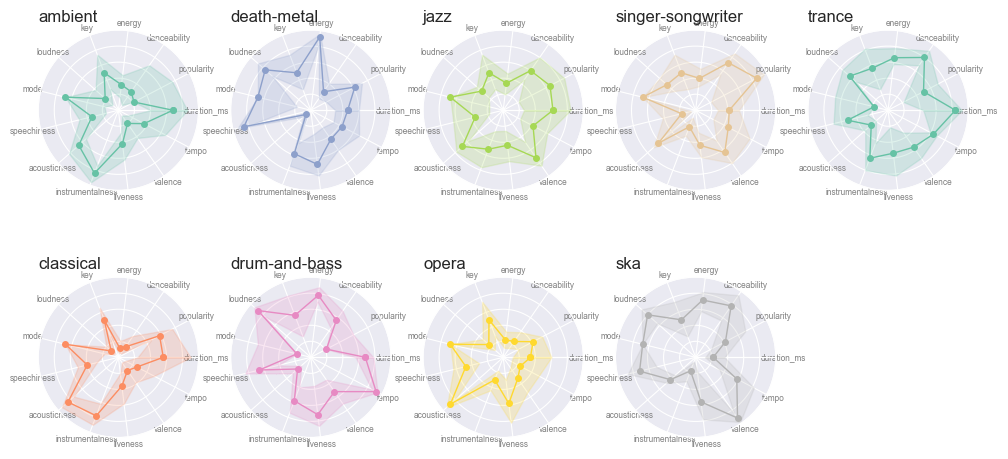

In [11]:
rows=2
my_palette = sns.color_palette("Set2")
q = int(len(normalized_stats)/rows)+len(normalized_stats)%rows
fig, axs = plt.subplots(rows, q, subplot_kw=dict(polar=True))

for i in range(rows*q):
    if i<len(normalized_stats):
        plot_radar_chart_stats(normalized_stats_25.iloc[i],
                               normalized_stats_50.iloc[i],
                               normalized_stats_75.iloc[i],
                               my_palette[i%8],axs[i%rows, int(i/rows)])
    else:
        fig.delaxes(axs[i%rows, int(i/rows)])

plt.savefig('radar_chart.png',dpi=800, bbox_inches = 'tight', pad_inches = 0)


Gráfico Radar de los features por cada género del set de datos.

La línea gruesa indica la mediana, y el sombreado es el rango intercuartil.

Las características se encuentran escaladas y normalizadas por cuantiles (dando una medición robusta de cada feature para hacer las estadísticas comparables)

- Análisis de este gráfico
    - La ópera y la clásica son los que más acousticness tienen.
    - Las canciones de trance son las que en general suelen tener mayor duración (seguidas por las ambient y drum-and-bass).
    - La música ambient y classical son las de mayor instrumentalness.
    - Death-metal suelen ser el género de mayor liveness junto con drum-and-bass.
    - Death-metal es incuestionablemente el género más energético, seguido por drum-and-bass, ska y trance.
    - Opera y classical comparten las característica de baja energy, baja valence, bajo tempo, alto acousticness y bajo speechness.
    - Los géneros más danceable son singer-songwriter, trance, jazz y ska.
    - La variable de popularidad corre a lo largo de todo el espectro para la mayoría de los géneros y ninguno muestra una amplia diferencia con respecto al resto. Más allá de eso, las canciones de singer-songwriter tienen (en media) las canciones más populares, seguidos por jazz y classical.    

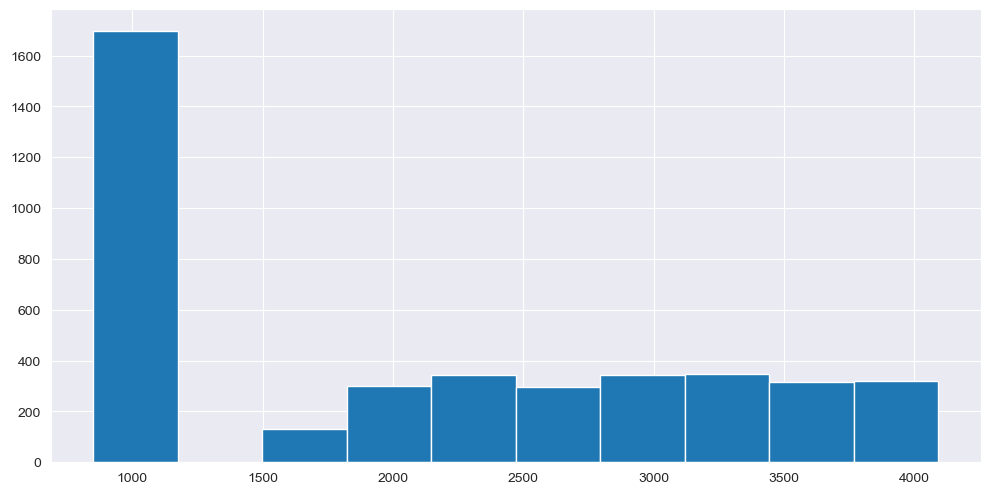

In [12]:
df_m['popularity'].rank().hist()

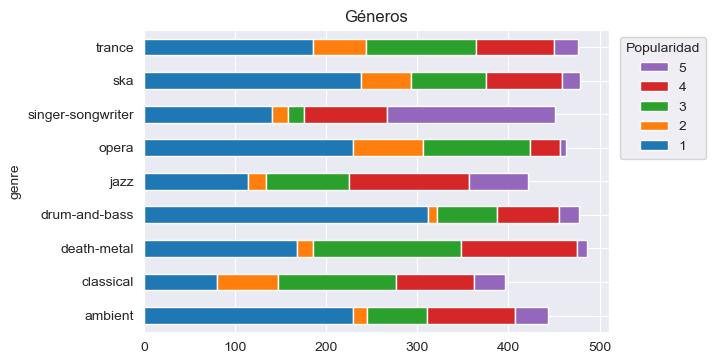

In [33]:
df2 = df_m.copy()

df2['popularity'] = np.round(df2['popularity'].rank().mul(5/len(df_m))).astype(int)
df3 = df2.groupby(['genre', 'popularity'])['genre'].count().unstack('popularity').fillna(0)

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1, 1, 1)

df3.plot(kind='barh', stacked=True,ax=ax)

#plt.xticks(rotation=45,ha='right')
plt.title('Géneros')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Popularidad', loc='upper left', bbox_to_anchor=(1.01, 1))

plt.savefig('generos.png',dpi=400, bbox_inches = 'tight', pad_inches = 0)


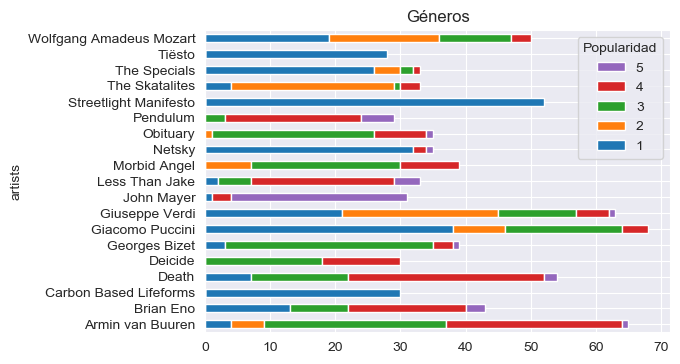

In [59]:
art = df2.groupby(['artists']).size().sort_values(ascending=False)[1:20].index
df4 = df2[df2['artists'].isin(art)]
df4 = df4.groupby(['artists', 'popularity'])['artists'].count().unstack('popularity').fillna(0)

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1, 1, 1)

df4.plot(kind='barh', stacked=True,ax=ax)

#plt.xticks(rotation=45,ha='right')
plt.title('Artistas')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Popularidad', loc='upper right')

plt.savefig('artistas.png',dpi=400, bbox_inches = 'tight', pad_inches = 0)


In [55]:
art = df2.groupby(['artists']).size().sort_values(ascending=False)[1:20].index
df4 = df2[df2['artists'].isin(art)]
df4

album  \
id                                                                          
18mjTyCpqUWuF1HedQZW4s  {'album_type': 'ALBUM', 'artists': [{'external...   
1Z43fZwZBbyx2Z9EkWvNs5  {'album_type': 'ALBUM', 'artists': [{'external...   
53KU8BrYZuxZOb3jqDm4ix  {'album_type': 'ALBUM', 'artists': [{'external...   
0T02WlrUAK45ApAVVixmcc  {'album_type': 'ALBUM', 'artists': [{'external...   
6gKtGkDTPjVMsWt02bGCHn  {'album_type': 'ALBUM', 'artists': [{'external...   
...                                                                   ...   
3HaVjlKejQmzj6hqivJ6Kv  {'album_type': 'ALBUM', 'artists': [{'external...   
29CO5ZEqcKECcvGGrtDTcD  {'album_type': 'ALBUM', 'artists': [{'external...   
3lJbKB0A7wo8HbtlsQep76  {'album_type': 'ALBUM', 'artists': [{'external...   
1ToMiCEVifC7DtOTSYZRlD  {'album_type': 'ALBUM', 'artists': [{'external...   
55ZR95Uzx08i0luEovZjXp  {'album_type': 'ALBUM', 'artists': [{'external...   

                                        artists  \
id                                                
18mjTyCpqUWuF1HedQZW4s           Giuseppe Verdi   
1Z43fZwZBbyx2Z9EkWvNs5  Wolfgang Amadeus Mozart   
53KU8BrYZuxZOb3jqDm4ix  Wolfgang Amadeus Mozart   
0T02WlrUAK45ApAVVixmcc          Giacomo Puccini   
6gKtGkDTPjVMsWt02bGCHn  Wolfgang Amadeus Mozart   
...                                         ...   
3HaVjlKejQmzj6hqivJ6Kv         Armin van Buuren   
29CO5ZEqcKECcvGGrtDTcD         Armin van Buuren   
3lJbKB0A7wo8HbtlsQep76         Armin van Buuren   
1ToMiCEVifC7DtOTSYZRlD         Armin van Buuren   
55ZR95Uzx08i0luEovZjXp         Armin van Buuren   

                                                        available_markets  \
id                                                                          
18mjTyCpqUWuF1HedQZW4s                                                 []   
1Z43fZwZBbyx2Z9EkWvNs5  [AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...   
53KU8BrYZuxZOb3jqDm4ix  [AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...   
0T02WlrUAK45ApAVVixmcc  [AD, AE, AL, AR, AT, AU, BA, BE, BG, BO, BR, B...   
6gKtGkDTPjVMsWt02bGCHn  [AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...   
...                                                                   ...   
3HaVjlKejQmzj6hqivJ6Kv  [AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...   
29CO5ZEqcKECcvGGrtDTcD  [AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...   
3lJbKB0A7wo8HbtlsQep76  [AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...   
1ToMiCEVifC7DtOTSYZRlD  [AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...   
55ZR95Uzx08i0luEovZjXp  [AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...   

                        disc_number  duration_ms  explicit  \
id                                                           
18mjTyCpqUWuF1HedQZW4s            1       137160     False   
1Z43fZwZBbyx2Z9EkWvNs5            1       511466     False   
53KU8BrYZuxZOb3jqDm4ix            1       468133     False   
0T02WlrUAK45ApAVVixmcc            1       311973     False   
6gKtGkDTPjVMsWt02bGCHn            2       650744     False   
...                             ...          ...       ...   
3HaVjlKejQmzj6hqivJ6Kv            1       260304     False   
29CO5ZEqcKECcvGGrtDTcD            1       128466     False   
3lJbKB0A7wo8HbtlsQep76            1       368640     False   
1ToMiCEVifC7DtOTSYZRlD            1       385746     False   
55ZR95Uzx08i0luEovZjXp            1       308773     False   

                                                            external_urls  \
id                                                                          
18mjTyCpqUWuF1HedQZW4s  {'spotify': 'https://open.spotify.com/track/18...   
1Z43fZwZBbyx2Z9EkWvNs5  {'spotify': 'https://open.spotify.com/track/1Z...   
53KU8BrYZuxZOb3jqDm4ix  {'spotify': 'https://open.spotify.com/track/53...   
0T02WlrUAK45ApAVVixmcc  {'spotify': 'https://open.spotify.com/track/0T...   
6gKtGkDTPjVMsWt02bGCHn  {'spotify': 'https://open.spotify.com/track/6g...   
...                                                   

In [15]:
df_m.columns.values

array(['album', 'artists', 'available_markets', 'disc_number',
       'duration_ms', 'explicit', 'external_urls', 'is_local', 'name',
       'popularity', 'track_number', 'genre', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature'], dtype=object)

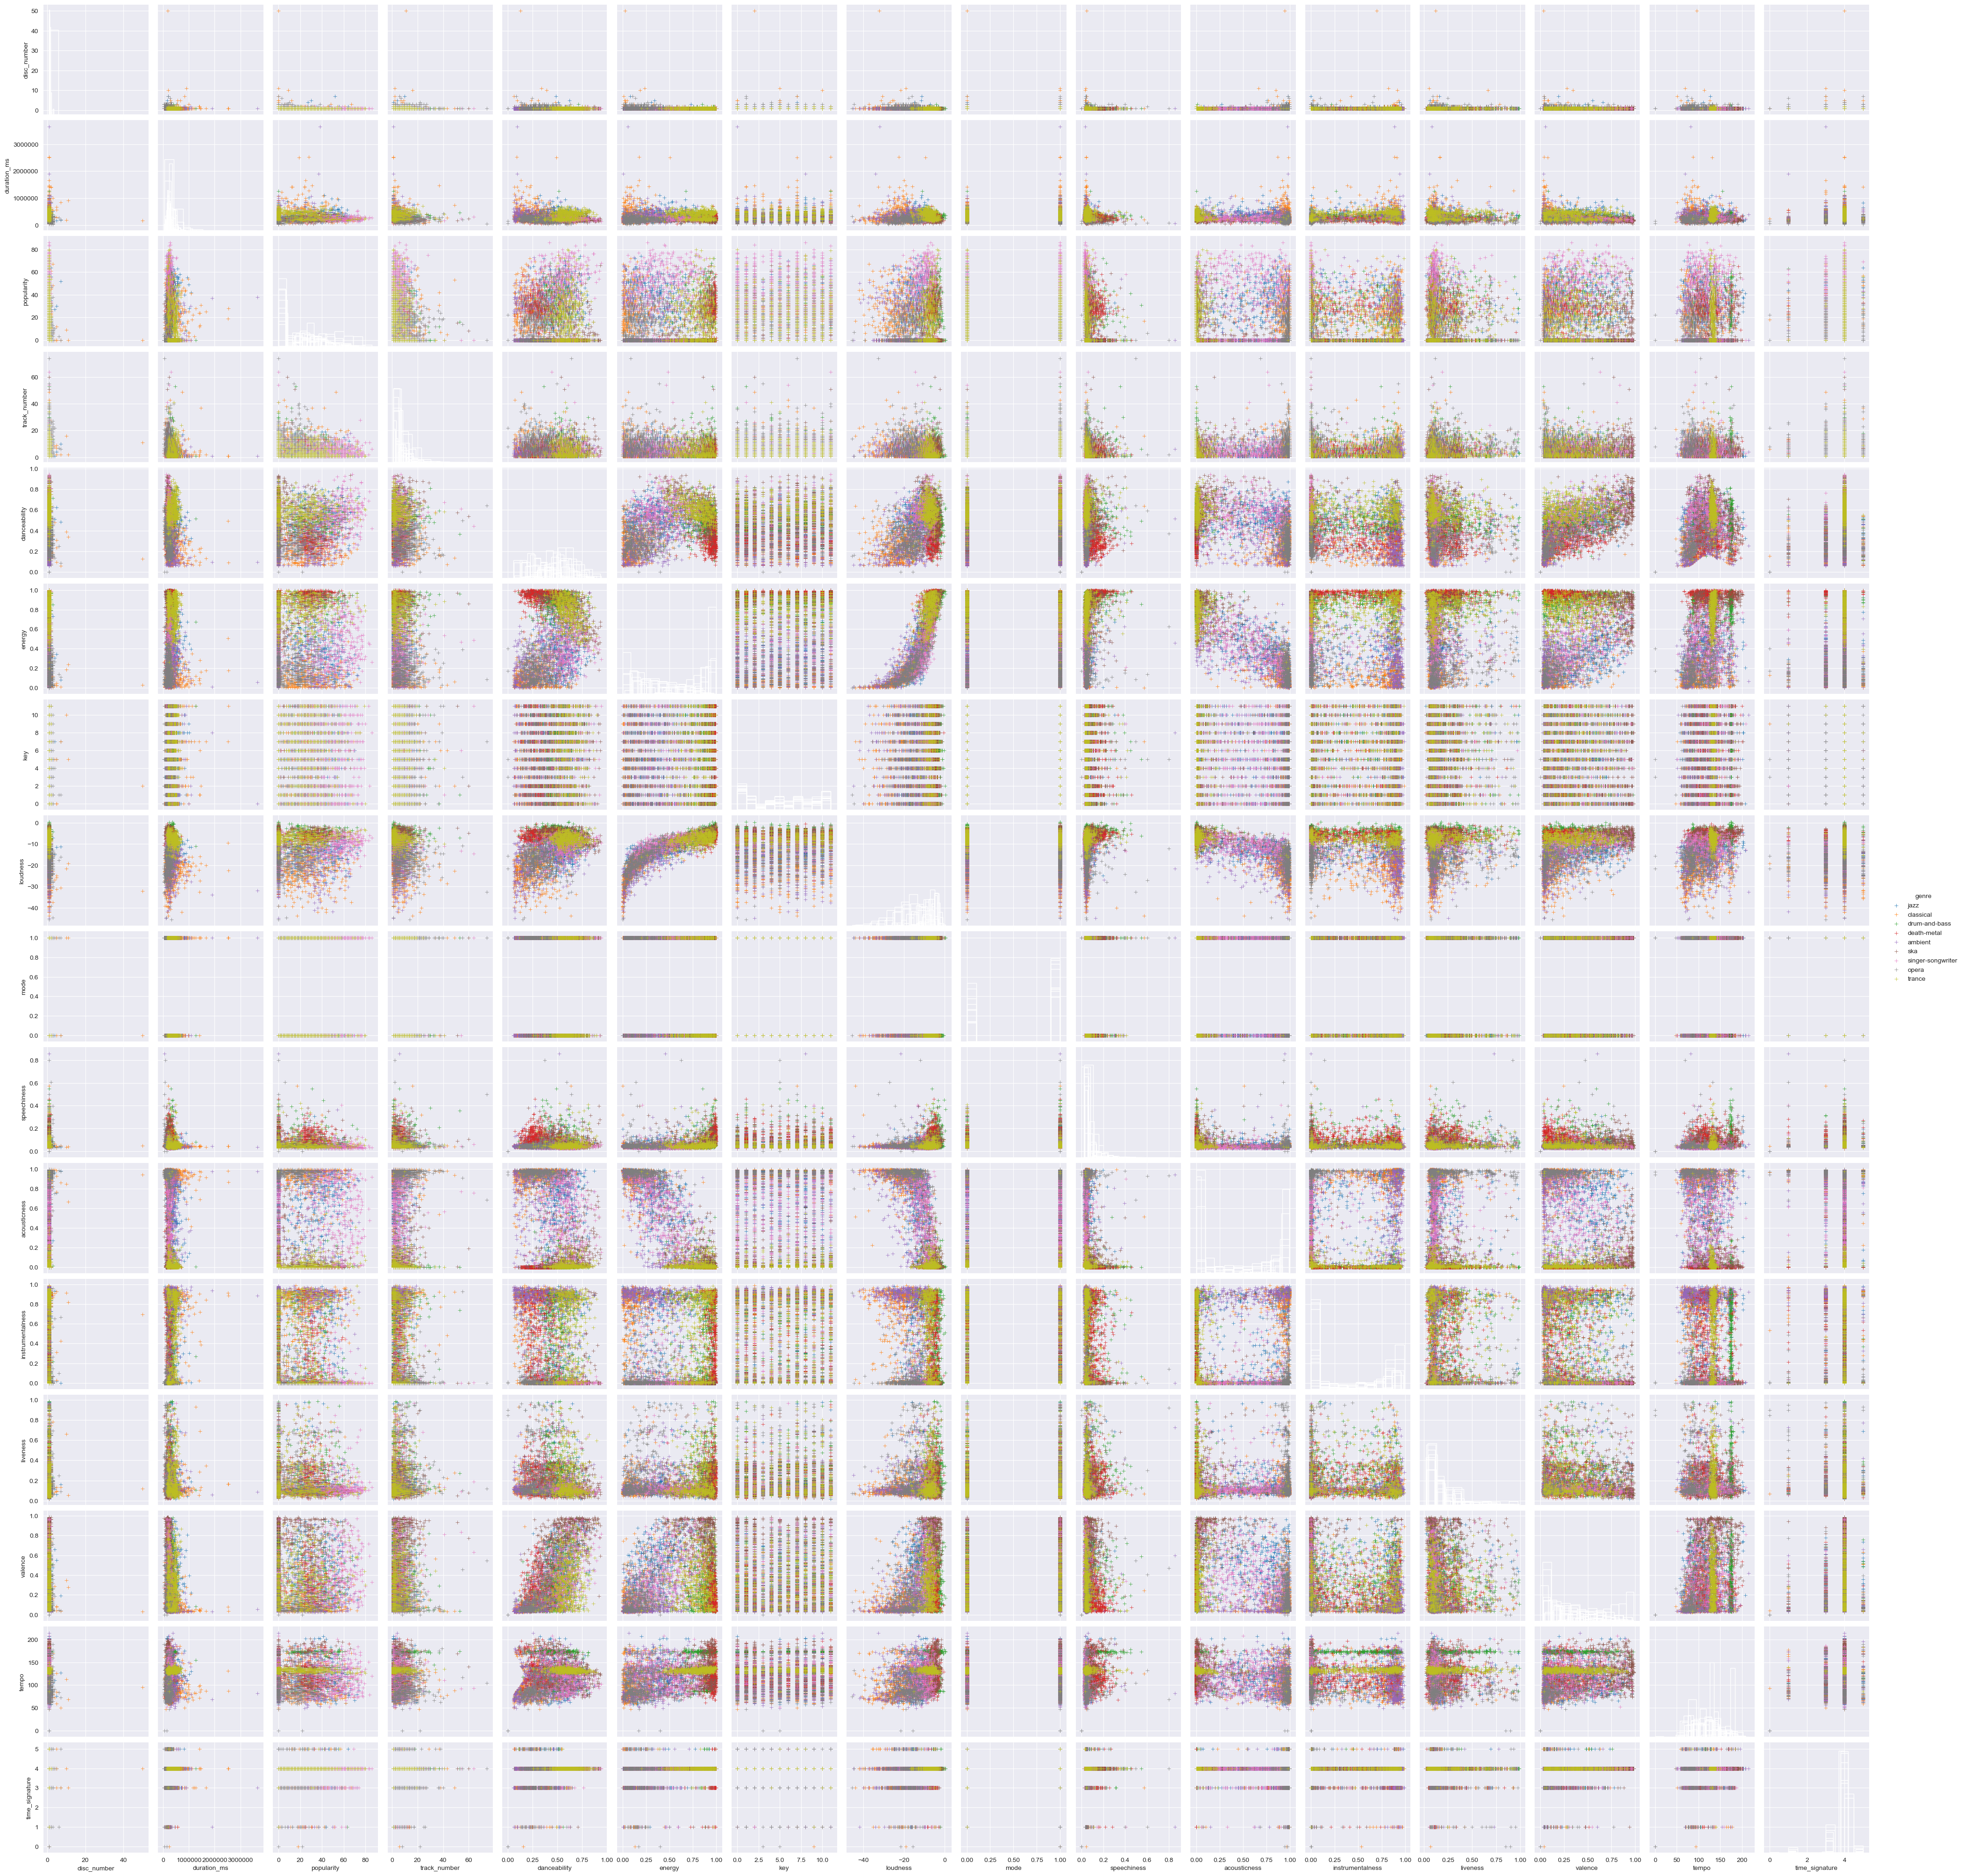

In [16]:
data_plot = df_m.select_dtypes(include=[np.number]).dropna()
data_plot['genre']=df_m['genre']

# Plot numerical values
scatterplots = sns.pairplot(data_plot, hue='genre', diag_kind="hist",
    plot_kws=dict(marker="+", linewidth=.5),
    diag_kws=dict(fill=False),)
#scatterplots.savefig('scatterplots.png')
scatterplots

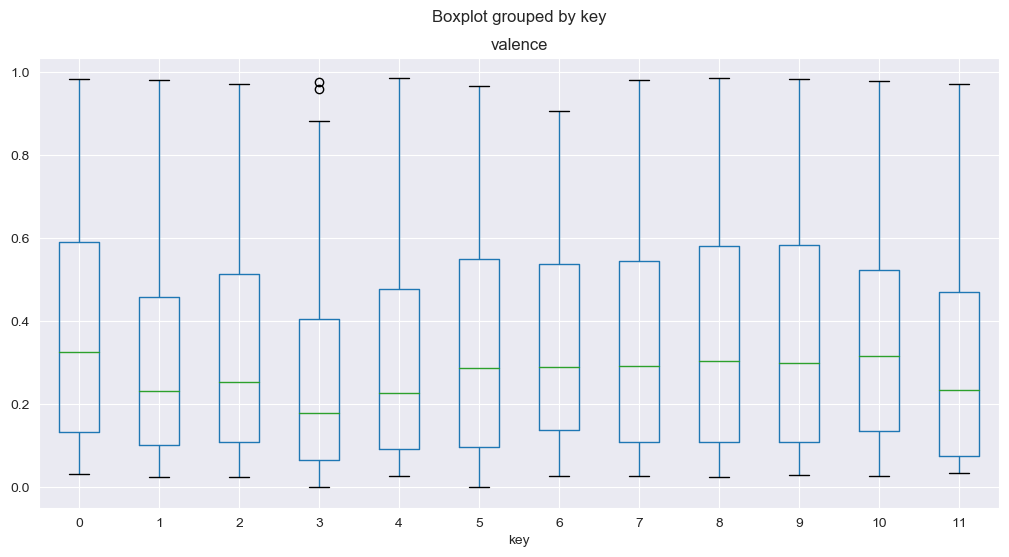

In [17]:
df_m.boxplot('valence','key')

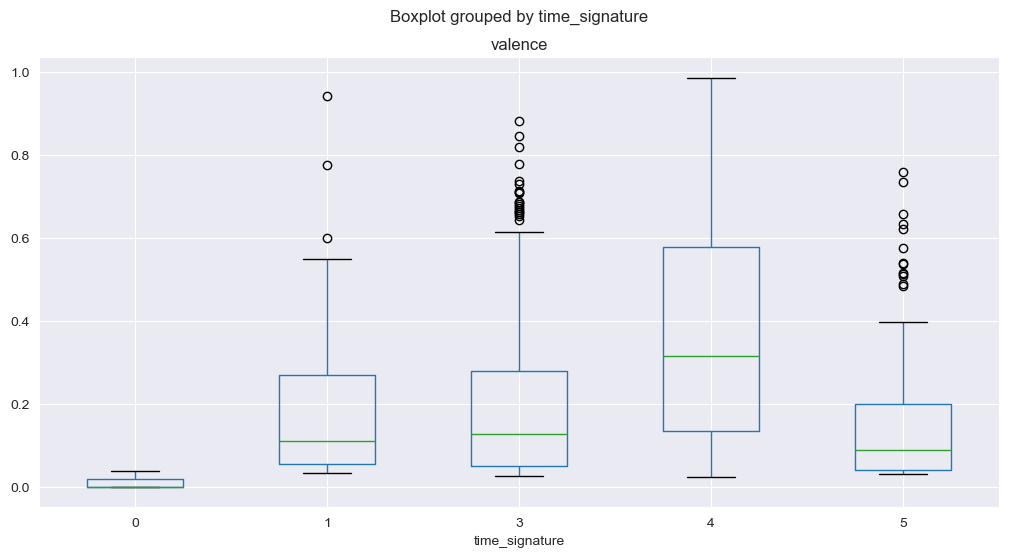

In [18]:
df_m.boxplot('valence','time_signature')